In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [6]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print('Norm complete')

Norm complete


In [7]:
print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [8]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [9]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [116]:
import torch.nn as nn
import torch.nn.functional as F
import time

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []

def allBelowThresh(losses, thresh):
    for loss,thr in zip(losses, thresh):
        if loss > thr:
            return False
    return True

def flatten(res):
    flat = [r for re in res for r in re]
    return flat

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    nTasks = len(res[0])
    avg = []
    for task in range(nTasks):
        avg.append(0)
        for para in range(nPara):
            avg[-1] += res[para][task]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, nTasks, inp, dp=0.5, edp=0.1, wInit=1e-4, dimA=10, dimB=2, temp=1):
        super(LatSim, self).__init__()
        self.nTasks = nTasks
        self.A = nn.Parameter(wInit*torch.randn(2,inp.shape[-1],dimA).float().cuda())
        self.B = nn.Parameter(wInit*torch.randn(2+arith(2),nTasks,dimA,dimB).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.t = temp if isinstance(temp, list) else nTasks*[temp]
    
    def getLatent(self, x, para):
        return x[:,para]@self.A[para]
    
    def getEdges(self, A, para, task):
        e = 1e-10
        z = A@self.B[para, task]
        e = e+z@z.T
        return e
        
    def forward(self, x, ys, testIdcs=None):
        assert self.B.shape[1] == len(ys), "business end targets dim not same as passed"
        x = self.dp(x)
        res = []
        As = []
        es = []
        for para in range(2):
            A = self.getLatent(x, para)
            As.append(F.relu(A))
        As.append(As[0]+As[1])
        for para,A in enumerate(As):
            res.append([])
            for task,y in enumerate(ys):
                e = self.getEdges(A, para, task)
                if testIdcs is not None:
                    e[:,testIdcs] = 0
                e = mask(e)
                e = self.edp(e)
                e[e == 0] = float('-inf')
                e = F.softmax(e/self.t[task], dim=1)
                res[-1].append(e@y)
        return res, As, es

def validate(model, X, ys, testIdcs):
    model.eval()
    losses = []
    with torch.no_grad():
        res, _, _ = model(X, ys, testIdcs)
        # for r,y in zip(res, ys):
        for r,y in zip(getAvg(res), ys):
            if y.dim() == 1:
                loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
                losses.append(loss)
            else:
                corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
                loss = torch.sum(corr)/len(testIdcs)
                losses.append(loss)
    model.train()
    return losses

nEpochs = 400
pPeriod = 10
thresh = [20] #[20,0.3,10]
regParam = [1,1e3,50]

for grp in range(10):
    trainIdcs = groups[grp][0][0:496]
    trainValidIdcs = groups[grp][0]
    validIdcs = np.arange(496,len(trainValidIdcs))
    testIdcs = groups[grp][1]

    X0 = nback_p_t
    X1 = emoid_p_t

    X = torch.stack([X0, X1], dim=1)
    Xt = X[trainIdcs]
    Xtv = X[trainValidIdcs]

    yy = [age_t, gen_t, wrt_t]
    yt = [age_t[trainIdcs], gen_t[trainIdcs], wrt_t[trainIdcs]]
    ytv = [age_t[trainValidIdcs], gen_t[trainValidIdcs], wrt_t[trainValidIdcs]]

    nTasks = len(yy)

    sim = LatSim(nTasks, X, dp=0.5, edp=0.1, wInit=1e-4, dimA=40, dimB=2, temp=[1,1,1])
    optim = torch.optim.Adam(sim.parameters(), lr=5e-4, weight_decay=5e-4)

    validLoss = [[] for _ in range(nTasks)]

    for epoch in range(nEpochs):
        optim.zero_grad()
        res, _, _ = sim(Xt, yt)
        loss = []
        for i,(r,y) in enumerate(zip(flatten(res)+getAvg(res), (X.shape[1]+1)*yt)):
            if y.dim() > 1:
                loss.append(regParam[i%nTasks]*ceLoss(r, y))
            else:
                loss.append(regParam[i%nTasks]*mseLoss(r, y))
        sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or allBelowThresh(loss[0:nTasks], thresh):
            print(f'epoch {epoch} loss={loss}')
            losses = validate(sim, Xtv, ytv, validIdcs)
            for i,lss in enumerate(losses):
                if (len(validLoss[i]) == 0 or 
                        (yy[i].dim() == 1 and lss < min(validLoss[i])) or 
                        (yy[i].dim() > 1 and lss > max(validLoss[i]))):
                    print(f'New best validation epoch {epoch} {i} loss={lss}')
                    torch.save(sim.state_dict(), f'../../Work/LatentSim/sim{i}.pyt')
                    validLoss[i].append(float(lss))
            if allBelowThresh(loss[0:nTasks], thresh):
                print('Early stopping')
                break

    finalLoss = []

    for i in range(nTasks):
        sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{i}.pyt'))
        loss = validate(sim, X, yy, testIdcs)
        finalLoss.append(float(loss[i]))

    rmse.append(finalLoss)

    print(f'FINISHED {rmse}')

epoch 0 loss=[tensor(1516.8324, device='cuda:0', grad_fn=<MulBackward0>), tensor(692.4996, device='cuda:0', grad_fn=<MulBackward0>), tensor(13406.2129, device='cuda:0', grad_fn=<MulBackward0>), tensor(1516.0981, device='cuda:0', grad_fn=<MulBackward0>), tensor(692.4052, device='cuda:0', grad_fn=<MulBackward0>), tensor(13341.4521, device='cuda:0', grad_fn=<MulBackward0>), tensor(1511.2174, device='cuda:0', grad_fn=<MulBackward0>), tensor(692.4229, device='cuda:0', grad_fn=<MulBackward0>), tensor(13354.1689, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 0 0 loss=44.578433990478516
New best validation epoch 0 1 loss=0.5
New best validation epoch 0 2 loss=12.045477867126465
epoch 10 loss=[tensor(1257.2692, device='cuda:0', grad_fn=<MulBackward0>), tensor(687.3305, device='cuda:0', grad_fn=<MulBackward0>), tensor(11686.7949, device='cuda:0', grad_fn=<MulBackward0>), tensor(1298.7557, device='cuda:0', grad_fn=<MulBackward0>), tensor(686.2570, device='cuda:0', grad_fn=<M

epoch 150 loss=[tensor(28.9559, device='cuda:0', grad_fn=<MulBackward0>), tensor(325.0162, device='cuda:0', grad_fn=<MulBackward0>), tensor(386.1183, device='cuda:0', grad_fn=<MulBackward0>), tensor(32.7040, device='cuda:0', grad_fn=<MulBackward0>), tensor(363.1655, device='cuda:0', grad_fn=<MulBackward0>), tensor(266.9780, device='cuda:0', grad_fn=<MulBackward0>), tensor(18.8010, device='cuda:0', grad_fn=<MulBackward0>), tensor(321.5193, device='cuda:0', grad_fn=<MulBackward0>), tensor(248.2492, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 150 1 loss=0.7258064150810242
epoch 160 loss=[tensor(26.3048, device='cuda:0', grad_fn=<MulBackward0>), tensor(323.4710, device='cuda:0', grad_fn=<MulBackward0>), tensor(304.4158, device='cuda:0', grad_fn=<MulBackward0>), tensor(31.4098, device='cuda:0', grad_fn=<MulBackward0>), tensor(338.0212, device='cuda:0', grad_fn=<MulBackward0>), tensor(250.9631, device='cuda:0', grad_fn=<MulBackward0>), tensor(16.8759, device='cuda:0',

epoch 90 loss=[tensor(74.9961, device='cuda:0', grad_fn=<MulBackward0>), tensor(648.7789, device='cuda:0', grad_fn=<MulBackward0>), tensor(307.2820, device='cuda:0', grad_fn=<MulBackward0>), tensor(49.1223, device='cuda:0', grad_fn=<MulBackward0>), tensor(619.3701, device='cuda:0', grad_fn=<MulBackward0>), tensor(303.0948, device='cuda:0', grad_fn=<MulBackward0>), tensor(36.1661, device='cuda:0', grad_fn=<MulBackward0>), tensor(586.7117, device='cuda:0', grad_fn=<MulBackward0>), tensor(173.5992, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 90 1 loss=0.6612902879714966
New best validation epoch 90 2 loss=10.564350128173828
epoch 100 loss=[tensor(60.2156, device='cuda:0', grad_fn=<MulBackward0>), tensor(617.9225, device='cuda:0', grad_fn=<MulBackward0>), tensor(333.9770, device='cuda:0', grad_fn=<MulBackward0>), tensor(38.5739, device='cuda:0', grad_fn=<MulBackward0>), tensor(558.9315, device='cuda:0', grad_fn=<MulBackward0>), tensor(378.1210, device='cuda:0', grad

epoch 10 loss=[tensor(1270.1833, device='cuda:0', grad_fn=<MulBackward0>), tensor(685.7547, device='cuda:0', grad_fn=<MulBackward0>), tensor(11803.5264, device='cuda:0', grad_fn=<MulBackward0>), tensor(1297.4022, device='cuda:0', grad_fn=<MulBackward0>), tensor(680.4330, device='cuda:0', grad_fn=<MulBackward0>), tensor(11632.5166, device='cuda:0', grad_fn=<MulBackward0>), tensor(1210.4982, device='cuda:0', grad_fn=<MulBackward0>), tensor(680.0398, device='cuda:0', grad_fn=<MulBackward0>), tensor(8416.5127, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 10 0 loss=38.46245193481445
New best validation epoch 10 1 loss=0.6129032373428345
New best validation epoch 10 2 loss=11.619773864746094
epoch 20 loss=[tensor(1174.7860, device='cuda:0', grad_fn=<MulBackward0>), tensor(680.4213, device='cuda:0', grad_fn=<MulBackward0>), tensor(3196.0938, device='cuda:0', grad_fn=<MulBackward0>), tensor(1124.6248, device='cuda:0', grad_fn=<MulBackward0>), tensor(669.3207, device='cud

epoch 160 loss=[tensor(26.1159, device='cuda:0', grad_fn=<MulBackward0>), tensor(320.3771, device='cuda:0', grad_fn=<MulBackward0>), tensor(258.1133, device='cuda:0', grad_fn=<MulBackward0>), tensor(29.7496, device='cuda:0', grad_fn=<MulBackward0>), tensor(369.7171, device='cuda:0', grad_fn=<MulBackward0>), tensor(271.2059, device='cuda:0', grad_fn=<MulBackward0>), tensor(16.5860, device='cuda:0', grad_fn=<MulBackward0>), tensor(329.5739, device='cuda:0', grad_fn=<MulBackward0>), tensor(148.4373, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 160 1 loss=0.7258064150810242
epoch 170 loss=[tensor(26.1534, device='cuda:0', grad_fn=<MulBackward0>), tensor(323.5728, device='cuda:0', grad_fn=<MulBackward0>), tensor(267.5442, device='cuda:0', grad_fn=<MulBackward0>), tensor(25.5881, device='cuda:0', grad_fn=<MulBackward0>), tensor(353.0090, device='cuda:0', grad_fn=<MulBackward0>), tensor(326.9763, device='cuda:0', grad_fn=<MulBackward0>), tensor(14.7469, device='cuda:0',

New best validation epoch 100 2 loss=10.780904769897461
epoch 110 loss=[tensor(31.7550, device='cuda:0', grad_fn=<MulBackward0>), tensor(391.9206, device='cuda:0', grad_fn=<MulBackward0>), tensor(257.3258, device='cuda:0', grad_fn=<MulBackward0>), tensor(34.7933, device='cuda:0', grad_fn=<MulBackward0>), tensor(425.1209, device='cuda:0', grad_fn=<MulBackward0>), tensor(268.7862, device='cuda:0', grad_fn=<MulBackward0>), tensor(18.7375, device='cuda:0', grad_fn=<MulBackward0>), tensor(341.5187, device='cuda:0', grad_fn=<MulBackward0>), tensor(155.0080, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 110 1 loss=0.7419354915618896
epoch 120 loss=[tensor(31.3427, device='cuda:0', grad_fn=<MulBackward0>), tensor(351.8713, device='cuda:0', grad_fn=<MulBackward0>), tensor(259.2880, device='cuda:0', grad_fn=<MulBackward0>), tensor(30.0037, device='cuda:0', grad_fn=<MulBackward0>), tensor(375.2713, device='cuda:0', grad_fn=<MulBackward0>), tensor(325.4366, device='cuda:0', g

epoch 90 loss=[tensor(62.8709, device='cuda:0', grad_fn=<MulBackward0>), tensor(664.6011, device='cuda:0', grad_fn=<MulBackward0>), tensor(327.4107, device='cuda:0', grad_fn=<MulBackward0>), tensor(54.4707, device='cuda:0', grad_fn=<MulBackward0>), tensor(635.1902, device='cuda:0', grad_fn=<MulBackward0>), tensor(313.4874, device='cuda:0', grad_fn=<MulBackward0>), tensor(30.8364, device='cuda:0', grad_fn=<MulBackward0>), tensor(628.3079, device='cuda:0', grad_fn=<MulBackward0>), tensor(191.2512, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 90 1 loss=0.596774160861969
epoch 100 loss=[tensor(45.6500, device='cuda:0', grad_fn=<MulBackward0>), tensor(653.8436, device='cuda:0', grad_fn=<MulBackward0>), tensor(353.4226, device='cuda:0', grad_fn=<MulBackward0>), tensor(43.6553, device='cuda:0', grad_fn=<MulBackward0>), tensor(612.2635, device='cuda:0', grad_fn=<MulBackward0>), tensor(315.8032, device='cuda:0', grad_fn=<MulBackward0>), tensor(22.6437, device='cuda:0', gr

epoch 50 loss=[tensor(260.5148, device='cuda:0', grad_fn=<MulBackward0>), tensor(676.3286, device='cuda:0', grad_fn=<MulBackward0>), tensor(421.2740, device='cuda:0', grad_fn=<MulBackward0>), tensor(316.9224, device='cuda:0', grad_fn=<MulBackward0>), tensor(664.2495, device='cuda:0', grad_fn=<MulBackward0>), tensor(471.9619, device='cuda:0', grad_fn=<MulBackward0>), tensor(206.1087, device='cuda:0', grad_fn=<MulBackward0>), tensor(666.1461, device='cuda:0', grad_fn=<MulBackward0>), tensor(304.8628, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 50 0 loss=22.092008590698242
epoch 60 loss=[tensor(165.9139, device='cuda:0', grad_fn=<MulBackward0>), tensor(674.3843, device='cuda:0', grad_fn=<MulBackward0>), tensor(347.1661, device='cuda:0', grad_fn=<MulBackward0>), tensor(190.2077, device='cuda:0', grad_fn=<MulBackward0>), tensor(663.6176, device='cuda:0', grad_fn=<MulBackward0>), tensor(420.3121, device='cuda:0', grad_fn=<MulBackward0>), tensor(120.4583, device='cuda:

New best validation epoch 0 2 loss=13.026070594787598
epoch 10 loss=[tensor(1241.8069, device='cuda:0', grad_fn=<MulBackward0>), tensor(676.7086, device='cuda:0', grad_fn=<MulBackward0>), tensor(11082.2773, device='cuda:0', grad_fn=<MulBackward0>), tensor(1246.8296, device='cuda:0', grad_fn=<MulBackward0>), tensor(675.4923, device='cuda:0', grad_fn=<MulBackward0>), tensor(11443.9355, device='cuda:0', grad_fn=<MulBackward0>), tensor(1186.8843, device='cuda:0', grad_fn=<MulBackward0>), tensor(672.1816, device='cuda:0', grad_fn=<MulBackward0>), tensor(8983.2080, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 10 0 loss=37.98009490966797
New best validation epoch 10 1 loss=0.596774160861969
New best validation epoch 10 2 loss=12.48223876953125
epoch 20 loss=[tensor(1050.4836, device='cuda:0', grad_fn=<MulBackward0>), tensor(674.0699, device='cuda:0', grad_fn=<MulBackward0>), tensor(2698.5889, device='cuda:0', grad_fn=<MulBackward0>), tensor(1087.3586, device='cuda:0', g

New best validation epoch 0 2 loss=12.014230728149414
epoch 10 loss=[tensor(1279.0530, device='cuda:0', grad_fn=<MulBackward0>), tensor(688.4782, device='cuda:0', grad_fn=<MulBackward0>), tensor(12140.3164, device='cuda:0', grad_fn=<MulBackward0>), tensor(1274.9576, device='cuda:0', grad_fn=<MulBackward0>), tensor(683.9464, device='cuda:0', grad_fn=<MulBackward0>), tensor(11313.5010, device='cuda:0', grad_fn=<MulBackward0>), tensor(1210.9536, device='cuda:0', grad_fn=<MulBackward0>), tensor(682.4520, device='cuda:0', grad_fn=<MulBackward0>), tensor(10572.7266, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 10 0 loss=38.25052261352539
New best validation epoch 10 1 loss=0.6290322542190552
epoch 20 loss=[tensor(1143.4457, device='cuda:0', grad_fn=<MulBackward0>), tensor(683.8270, device='cuda:0', grad_fn=<MulBackward0>), tensor(4608.4722, device='cuda:0', grad_fn=<MulBackward0>), tensor(1124.8630, device='cuda:0', grad_fn=<MulBackward0>), tensor(667.4443, device='cud

epoch 140 loss=[tensor(26.2716, device='cuda:0', grad_fn=<MulBackward0>), tensor(336.8103, device='cuda:0', grad_fn=<MulBackward0>), tensor(259.5620, device='cuda:0', grad_fn=<MulBackward0>), tensor(28.2827, device='cuda:0', grad_fn=<MulBackward0>), tensor(341.2893, device='cuda:0', grad_fn=<MulBackward0>), tensor(237.8406, device='cuda:0', grad_fn=<MulBackward0>), tensor(18.0283, device='cuda:0', grad_fn=<MulBackward0>), tensor(322.8012, device='cuda:0', grad_fn=<MulBackward0>), tensor(149.7528, device='cuda:0', grad_fn=<MulBackward0>)]
epoch 150 loss=[tensor(27.3650, device='cuda:0', grad_fn=<MulBackward0>), tensor(328.0873, device='cuda:0', grad_fn=<MulBackward0>), tensor(234.4783, device='cuda:0', grad_fn=<MulBackward0>), tensor(24.5480, device='cuda:0', grad_fn=<MulBackward0>), tensor(334.0877, device='cuda:0', grad_fn=<MulBackward0>), tensor(363.0296, device='cuda:0', grad_fn=<MulBackward0>), tensor(15.7376, device='cuda:0', grad_fn=<MulBackward0>), tensor(317.9392, device='cuda:

epoch 40 loss=[tensor(634.0141, device='cuda:0', grad_fn=<MulBackward0>), tensor(671.9134, device='cuda:0', grad_fn=<MulBackward0>), tensor(568.4218, device='cuda:0', grad_fn=<MulBackward0>), tensor(382.9333, device='cuda:0', grad_fn=<MulBackward0>), tensor(668.6144, device='cuda:0', grad_fn=<MulBackward0>), tensor(669.2413, device='cuda:0', grad_fn=<MulBackward0>), tensor(397.9338, device='cuda:0', grad_fn=<MulBackward0>), tensor(665.1258, device='cuda:0', grad_fn=<MulBackward0>), tensor(466.9538, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 40 0 loss=23.490385055541992
New best validation epoch 40 2 loss=9.898178100585938
epoch 50 loss=[tensor(349.1287, device='cuda:0', grad_fn=<MulBackward0>), tensor(668.8375, device='cuda:0', grad_fn=<MulBackward0>), tensor(394.9568, device='cuda:0', grad_fn=<MulBackward0>), tensor(225.5902, device='cuda:0', grad_fn=<MulBackward0>), tensor(669.9502, device='cuda:0', grad_fn=<MulBackward0>), tensor(463.3947, device='cuda:0', g

New best validation epoch 0 1 loss=0.5161290168762207
New best validation epoch 0 2 loss=12.230083465576172
epoch 10 loss=[tensor(1210.2446, device='cuda:0', grad_fn=<MulBackward0>), tensor(685.3641, device='cuda:0', grad_fn=<MulBackward0>), tensor(11656.0303, device='cuda:0', grad_fn=<MulBackward0>), tensor(1228.8386, device='cuda:0', grad_fn=<MulBackward0>), tensor(678.9679, device='cuda:0', grad_fn=<MulBackward0>), tensor(11275.2725, device='cuda:0', grad_fn=<MulBackward0>), tensor(1139.0625, device='cuda:0', grad_fn=<MulBackward0>), tensor(678.8543, device='cuda:0', grad_fn=<MulBackward0>), tensor(8878.0225, device='cuda:0', grad_fn=<MulBackward0>)]
New best validation epoch 10 0 loss=39.5224494934082
New best validation epoch 10 1 loss=0.6612902879714966
New best validation epoch 10 2 loss=12.092679023742676
epoch 20 loss=[tensor(1016.0625, device='cuda:0', grad_fn=<MulBackward0>), tensor(676.3583, device='cuda:0', grad_fn=<MulBackward0>), tensor(3964.9341, device='cuda:0', grad_f

FINISHED [[26.4591064453125, 0.8064515590667725, 12.426405906677246], [30.37251853942871, 0.7580645084381104, 13.241344451904297], [23.707944869995117, 0.8064515590667725, 12.197799682617188], [22.740089416503906, 0.7419354915618896, 15.506383895874023], [24.640853881835938, 0.8548386693000793, 13.8797607421875], [23.78717803955078, 0.7096773982048035, 13.847355842590332], [25.84549331665039, 0.7096773982048035, 16.19424057006836], [26.822906494140625, 0.7258064150810242, 15.266375541687012], [22.762495040893555, 0.7258064150810242, 14.441495895385742], [27.554515838623047, 0.6935483813285828, 16.046104431152344]]


In [117]:
print(sum([f[0] for f in rmse])/10/12)
print(sum([f[1] for f in rmse])/10)
print(sum([f[2] for f in rmse])/10)


2.1224425156911213
0.7532257795333862
14.304726696014404


In [67]:
sim.B[0,2]

tensor([[-0.0090,  0.0096],
        [ 0.0108, -0.0113],
        [-0.0087,  0.0093],
        [ 0.0123, -0.0122],
        [-0.0069,  0.0074],
        [-0.0030,  0.0037],
        [-0.0131,  0.0132],
        [ 0.0115, -0.0128],
        [-0.0063,  0.0067],
        [ 0.0071, -0.0075]], device='cuda:0', grad_fn=<SelectBackward0>)

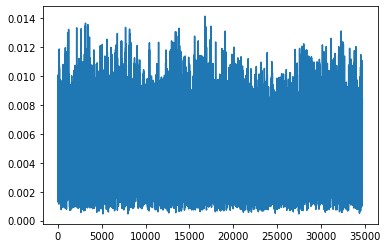

In [69]:
import matplotlib.pyplot as plt

plt.plot(torch.mean(torch.abs(sim.A[1].detach().cpu()), dim=1))
plt.show()